<a href="https://colab.research.google.com/github/rmezapi/dementia_vit/blob/main/Dementia_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project was intended to test the limits of the ViT on a tough dementia dataset. The data used can be found on HuggingFace at: https://huggingface.co/datasets/Falah/Alzheimer_MRI. The project follows closely the following tutorials:


*   https://www.youtube.com/watch?v=r88L_yLJ4CE&ab_channel=code_your_own_AI
*   https://www.youtube.com/watch?v=qU7wO02urYU&ab_channel=JamesBriggs  


I modify the code presented in the video and tune all parameters to optimize performance using mostly the same libraries and tools. This is a practice project for myself as I return to coding/designing ML models after dedicating time to AI/ML theory (model architectures, transfer learning)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install -q torch torchvision
import torch
import torchvision
import warnings
warnings.filterwarnings('ignore')

!pip install -q transformers datasets
!pip uninstall -q accelerate -y
!pip uninstall -q pytorch-accelerated -y
!pip install -q accelerate==0.21.0
!pip install -q transformers==4.26.0
!pip install -q transformers[torch]
!pip install transformers[utils]

In [2]:
from transformers import ViTConfig, ViTModel

# initalizing a ViT vit-patch-base16-224 configuration
config = ViTConfig()
# initialize a model w random weights
model = ViTModel(config)
# access the model config
config = model.config

In [3]:
config

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.26.0"
}

In [4]:
model

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [5]:
from transformers import ViTImageProcessor

from datasets import load_dataset

dataset = load_dataset("Falah/Alzheimer_MRI")


Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

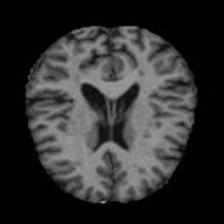

In [6]:
# preview the 1st image
image = dataset["train"][0]["image"].resize((224, 224))
image

In [7]:
# construct a ViT image processor
features = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
# load pretrained model on imagenet-21k
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [8]:
features.rescale_factor = 1
features.size = {'height':224, 'width':224}

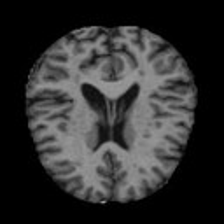

In [9]:
# add channels to image
image = image.convert(mode="RGB").resize((224, 224))

image

In [10]:
inputs = features(image, return_tensors="pt")

with torch.no_grad():
  outputs = model(**inputs)

In [11]:
last_hidden_state = outputs.last_hidden_state
last_hidden_state.shape

torch.Size([1, 197, 768])

In [12]:
model.config

ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.26.0"
}

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
def preprocess(batch):
  # Convert the images to RGB format (3 channels)
  images = [image.convert("RGB") for image in batch["image"]]

  # take a list of images and turn them into pixel values
  inputs = features(images, return_tensors="pt")
  # Check if the 'image' key is present
  if "image" in inputs:
      inputs.pop("image")

  # include the labels
  inputs["labels"] = batch["label"]
  return inputs

In [15]:
prepared_train = dataset["train"].with_transform(preprocess)
prepared_test = dataset["test"].with_transform(preprocess)

In [16]:
# collate function
def collate(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch])
  }

In [17]:
from datasets import load_metric

metric = load_metric("accuracy")
def metric_fn(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

In [18]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./dementia",
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.001,
    push_to_hub=False,
    report_to="none",
    load_best_model_at_end=True,
    save_total_limit=3,
    logging_steps=1,
    save_steps=1,
    remove_unused_columns=False
)

In [19]:
from transformers import ViTForImageClassification

labels = dataset["train"].features["label"].names
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels))

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [21]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=features,
    data_collator=collate,
    compute_metrics=metric_fn
)

In [22]:
# train and store results
train_results = trainer.train()
# save tokenizer w the model
trainer.save_model()
# log and save metrics
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()

***** Running training *****
  Num examples = 5120
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1600
  Number of trainable parameters = 85801732


Epoch,Training Loss,Validation Loss,Accuracy
1,0.817400,0.927409,0.560156
2,0.644300,0.892673,0.572656
3,0.716100,0.918184,0.576562
4,0.621800,0.833306,0.608594
5,0.720200,0.784546,0.659375


***** Running Evaluation *****
  Num examples = 1280
  Batch size = 8
Saving model checkpoint to ./dementia/checkpoint-320
Configuration saved in ./dementia/checkpoint-320/config.json
Model weights saved in ./dementia/checkpoint-320/pytorch_model.bin
Image processor saved in ./dementia/checkpoint-320/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1280
  Batch size = 8
Saving model checkpoint to ./dementia/checkpoint-640
Configuration saved in ./dementia/checkpoint-640/config.json
Model weights saved in ./dementia/checkpoint-640/pytorch_model.bin
Image processor saved in ./dementia/checkpoint-640/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1280
  Batch size = 8
Saving model checkpoint to ./dementia/checkpoint-960
Configuration saved in ./dementia/checkpoint-960/config.json
Model weights saved in ./dementia/checkpoint-960/pytorch_model.bin
Image processor saved in ./dementia/checkpoint-960/preprocessor_config.json
***** Running Evalu

***** train metrics *****
  epoch                    =          5.0
  total_flos               = 1847586123GF
  train_loss               =       0.8488
  train_runtime            =   0:05:25.55
  train_samples_per_second =       78.635
  train_steps_per_second   =        4.915


In [23]:
# view eval metrics
metrics = trainer.evaluate(prepared_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 1280
  Batch size = 8


***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.6594
  eval_loss               =     0.7845
  eval_runtime            = 0:00:06.63
  eval_samples_per_second =    192.794
  eval_steps_per_second   =     24.099


Ground Truth: Very_Mild_Demented (3)


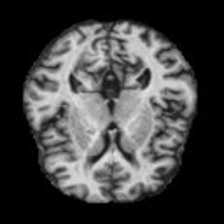

In [33]:
import random
from random import randint
n_sample = randint(0, len(dataset["test"]))
image = dataset["test"][n_sample]["image"].resize((224, 224))

# 0: mild_demented, 1: moderate_demented, 2: non_demented, 3: very_mild_demented

ground_truth = dataset["test"][n_sample]["label"]

print(f"Ground Truth: {labels[ground_truth]} ({ground_truth})")
image

Ground Truth: Very_Mild_Demented (3)
Predicted Label: Very_Mild_Demented (3)


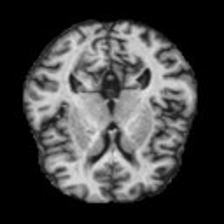

In [34]:
# check the model output
image = image.convert("RGB")
inputs = features(image, return_tensors="pt").to(device)
with torch.no_grad():
  outputs = model(**inputs).logits

predicted_label = torch.argmax(outputs).item()
print(f"Ground Truth: {labels[ground_truth]} ({ground_truth})")
print(f"Predicted Label: {labels[predicted_label]} ({predicted_label})")
image